In [1]:
import math
import random 
import collections
import numpy as np

import nest_asyncio
import tensorflow as tf
import tensorflow_federated as tff
import seaborn as sns

from tensorflow.keras import activations
from statistics import mean
from collections import Counter

from tqdm.notebook import tqdm as tqdm_notebook

from math import sqrt

sns.set_theme(style= 'whitegrid')
nest_asyncio.apply()
tff.backends.reference.set_reference_context()

### Data augmentation

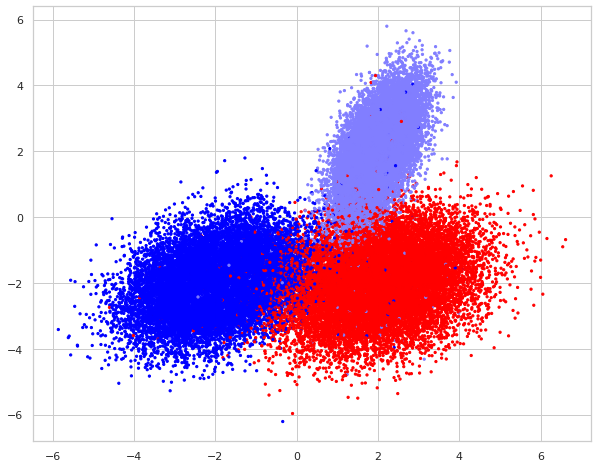

In [2]:
import matplotlib.colors
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import sklearn.datasets as dt

from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV

color_map_discrete = matplotlib.colors.LinearSegmentedColormap.from_list("", ["red","cyan","magenta","blue"])

x,y = dt.make_classification(n_samples=50000,
                                 n_features=2,
                                 n_repeated=0,
                                 class_sep=2, 
                                 n_redundant=0,
                                 n_classes=3,
                                 n_clusters_per_class=1,
                                 random_state=2000)

fig = plt.figure(figsize=(10,8))
my_scatter_plot = plt.scatter(x[:,0],
                                  x[:,1],
                                  c=y,
                                  vmin=min(y),
                                  vmax=max(y),
                                  s=5,
                                  cmap=color_map_discrete)

plt.show()

list0 = []
list1 = []
list2 = []

for a,b in zip(x,y):
    c = a.tolist()
    c.append(b)
    if b == 0:
        list0.append(c)
    elif b == 1:
        list1.append(c)
    else:
        list2.append(c)

client1 = []
client2 = []
client3 = []

l01 = math.ceil(len(list0)*0.7)
l02 = math.ceil(len(list0)*0.8)

l11 = math.ceil(len(list0)*0.6)
l12 = math.ceil(len(list0)*0.75)

l21 = math.ceil(len(list0)*0.65)
l22 = math.ceil(len(list0)*0.85)


CLIENT1 = list0[:l01] + list1[l11:l12] + list2[l22:]
CLIENT2 = list0[l02:] + list1[:l11] + list2[l21:l22]
CLIENT3 = list0[l01:l02] + list1[l12:] + list2[:l21]

random.shuffle(client1)
random.shuffle(client2)
random.shuffle(client3)

### Clients Data

In [3]:
def get_batches(HOLDER):
    federated_data = []
    for i in HOLDER:
        client = []
        for index in range(len(i)//100):
            X= []
            Y= []
            for elements in i[index*100:index*100+100]:
                X.append(np.array([np.float32(elements[0]),np.float32(elements[1])]))
                Y.append(np.array(np.int32(elements[2])))
            client.append({
                'x':np.array(X),
                'y':np.array(Y)
            })
        federated_data.append(client)
    return federated_data

In [4]:
def poissonDistributiondata(clientData):
    data = random.sample(clientData,2000)
    return [data[:1000],data[1000:1500],data[1500:]]

In [5]:
def reselectClientData():
    c1_tra, c1_val, c1_test = poissonDistributiondata(CLIENT1)
    c2_tra, c2_val, c2_test = poissonDistributiondata(CLIENT2)
    c3_tra, c3_val, c3_test = poissonDistributiondata(CLIENT3)

    train = [c1_tra,   c2_tra,  c3_tra]
    val   = [c1_val,   c2_val,  c3_val]
    test  = [c1_test, c2_test, c3_test]

    federated_train_data      =  get_batches(train)
    federated_validation_data =  get_batches(val)
    federated_test_data       =  get_batches(test)
    
    #count
    ARR.append([Counter(list(map(lambda x: x[-1], c1_tra))), 
                Counter(list(map(lambda x: x[-1], c2_tra))), 
                Counter(list(map(lambda x: x[-1], c3_tra)))])
    #mean
    
    return (federated_train_data,federated_validation_data,federated_test_data)

In [6]:
def get_mean(arr_history):
    client1_means = [i[0] for i in arr_history]
    client2_means = [i[1] for i in arr_history]
    client3_means = [i[2] for i in arr_history]
    
    client1_means_vals_c1 = [i.get(0) for i in client1_means]
    client1_means_vals_c2 = [i.get(1) for i in client1_means]    
    client1_means_vals_c3 = [i.get(2) for i in client1_means]    
    
    client2_means_vals_c1 = [i.get(0) for i in client2_means]
    client2_means_vals_c2 = [i.get(1) for i in client2_means]    
    client2_means_vals_c3 = [i.get(2) for i in client2_means] 
    
    client3_means_vals_c1 = [i.get(0) for i in client3_means]
    client3_means_vals_c2 = [i.get(1) for i in client3_means]    
    client3_means_vals_c3 = [i.get(2) for i in client3_means]  
    
    return {
        'client1':{
            0: mean(client1_means_vals_c1),
            1: mean(client1_means_vals_c2),
            2: mean(client1_means_vals_c3)
        },
        'client2':{
            0: mean(client2_means_vals_c1),
            1: mean(client2_means_vals_c2),
            2: mean(client2_means_vals_c3)
        },
        'client3':{
            0: mean(client3_means_vals_c1),
            1: mean(client3_means_vals_c2),
            2: mean(client3_means_vals_c3)
        }
    }

####  Follow shows the get mean output
```get_mean(ARR)```

```{'client1': {0: 706.5, 1: 154, 2: 139.5},
 'client2': {0: 188, 1: 611, 2: 201},
 'client3': {0: 92, 1: 245, 2: 663}}```

#### Custom mean aggregation function goes here

In [7]:
def AGG_FUNCTION1(mean):
    return [
        np.float32(max(mean.get('client1').values())),
        np.float32(max(mean.get('client2').values())),
        np.float32(max(mean.get('client3').values()))
    ]

In [8]:
def AGG_FUNCTION2(mean):
    return [
        np.float32(min(mean.get('client1').values())),
        np.float32(min(mean.get('client2').values())),
        np.float32(min(mean.get('client3').values())),
    ]

In [9]:
def AGG_FUNCTION3(mean):
    return [
        np.float32(sum(mean.get('client1').values())),
        np.float32(sum(mean.get('client2').values())),
        np.float32(sum(mean.get('client3').values())),
    ]

In [10]:
def AGG_FUNCTION4(mean):
    return [
        np.float32(sum(map(lambda x: x*x ,mean.get('client1').values()))),
        np.float32(sum(map(lambda x: x*x ,mean.get('client2').values()))),
        np.float32(sum(map(lambda x: x*x ,mean.get('client3').values()))),
    ]

In [11]:
def AGG_FUNCTION5(mean):
    return [
        np.float32(sqrt(sum(map(lambda x: x*x ,mean.get('client1').values())))),
        np.float32(sqrt(sum(map(lambda x: x*x ,mean.get('client2').values())))),
        np.float32(sqrt(sum(map(lambda x: x*x ,mean.get('client3').values())))),
    ]

In [12]:
def AGG_FUNCTION6():
    return [
        np.float32(random.uniform(1.1, 3.61)),
        np.float32(random.uniform(1.1, 3.61)),
        np.float32(random.uniform(1.1, 3.61)),
    ]

### Federated Data Types [Client and Server]

In [13]:
BATCH_SPEC = collections.OrderedDict(x=tf.TensorSpec(shape=[None, 2], dtype=tf.float32),
                                     y=tf.TensorSpec(shape=[None], dtype=tf.int32))
BATCH_TYPE = tff.to_type(BATCH_SPEC)


MODEL_SPEC = collections.OrderedDict(weights=tf.TensorSpec(shape=[2, 3], dtype=tf.float32),
                                     bias=tf.TensorSpec(shape=[3], dtype=tf.float32))
MODEL_TYPE = tff.to_type(MODEL_SPEC)


WEIGHT_SPEC = tff.TensorType(dtype=tf.float32, shape=None)
WEIGHT_TYPE = tff.to_type(WEIGHT_SPEC)
WEIGHT_DATA_TYPE = tff.FederatedType(WEIGHT_TYPE, tff.CLIENTS)

### Federated Client

In [14]:
@tf.function
def forward_pass(model, batch):
    predicted_y = tf.nn.softmax(tf.matmul(batch['x'], model['weights']) + model['bias'])
    return -tf.reduce_mean(tf.reduce_sum(tf.one_hot(batch['y'], 3) * tf.math.log(predicted_y), axis=[1]))

@tff.tf_computation(MODEL_TYPE, BATCH_TYPE)
def batch_loss(model, batch):
    return forward_pass(model, batch)

In [15]:
@tff.tf_computation(MODEL_TYPE, BATCH_TYPE, tf.float32)
def batch_train(initial_model, batch, learning_rate):
    model_vars = collections.OrderedDict([
        (name, tf.Variable(name=name, initial_value=value))
        for name, value in initial_model.items()
    ])
    optimizer = tf.keras.optimizers.SGD(learning_rate)
    
    @tf.function
    def _train_on_batch(model_vars, batch):
        with tf.GradientTape() as tape:
            loss = forward_pass(model_vars, batch)
        grads = tape.gradient(loss, model_vars)
        optimizer.apply_gradients(zip(tf.nest.flatten(grads), tf.nest.flatten(model_vars)))
        return model_vars
  
    return _train_on_batch(model_vars, batch)

In [16]:
LOCAL_DATA_TYPE = tff.SequenceType(BATCH_TYPE)

@tff.federated_computation(MODEL_TYPE, tf.float32, LOCAL_DATA_TYPE)
def local_train(initial_model, learning_rate, all_batches):
    @tff.federated_computation(MODEL_TYPE, BATCH_TYPE)
    def batch_fn(model, batch):
        return batch_train(model, batch, learning_rate)
    return tff.sequence_reduce(all_batches, initial_model, batch_fn)

In [17]:
@tff.federated_computation(MODEL_TYPE, LOCAL_DATA_TYPE)
def local_eval(model, all_batches):
    return tff.sequence_sum(tff.sequence_map(tff.federated_computation(lambda b: batch_loss(model, b), BATCH_TYPE),all_batches))

### Federated Server

In [18]:
SERVER_MODEL_TYPE = tff.type_at_server(MODEL_TYPE)
CLIENT_DATA_TYPE = tff.type_at_clients(LOCAL_DATA_TYPE)

In [19]:
@tff.federated_computation(SERVER_MODEL_TYPE, CLIENT_DATA_TYPE)
def federated_eval(model, data):
    return tff.federated_mean(tff.federated_map(local_eval, [tff.federated_broadcast(model), data]))

SERVER_FLOAT_TYPE

In [20]:
SERVER_FLOAT_TYPE = tff.type_at_server(tf.float32)

#### With custom weighting factors

In [21]:
@tff.federated_computation(SERVER_MODEL_TYPE, SERVER_FLOAT_TYPE,CLIENT_DATA_TYPE, WEIGHT_DATA_TYPE)
def federated_train(model, learning_rate, data, weights):
    return tff.federated_mean(
          tff.federated_map(local_train, [
          tff.federated_broadcast(model),
          tff.federated_broadcast(learning_rate), data]), weights)

def modelR(weights, biases, data):
    count = 0
    avg = 0
    for j in range(len(federated_test_data[0])):
        l = [np.where(i==max(i))[0][0] for i in activations.sigmoid(np.matmul(federated_test_data[0][j].get('x'), model.get('weights'))).numpy()]
        Y = federated_test_data[0][j].get('y')
        
        for i in range(len(Y)):
            avg+=1
            if l[i] == Y[i]:
                count+= 1
                
    return count/avg

#### Without custom weighting factors

In [22]:
@tff.federated_computation(SERVER_MODEL_TYPE, SERVER_FLOAT_TYPE,CLIENT_DATA_TYPE)
def federated_train_2(model, learning_rate, data):
    return tff.federated_mean(
          tff.federated_map(local_train, [
          tff.federated_broadcast(model),
          tff.federated_broadcast(learning_rate), data]))

In [23]:
# # initial_model, learning_rate, all_batches
# from collections import OrderedDict
# def newFL(model, learning_rate, data,w):
    
#     od = OrderedDict()
    
#     c1w = local_train(model, learning_rate, data[0])
#     c2w = local_train(model, learning_rate, data[1])    
#     c3w = local_train(model, learning_rate, data[2])
    
#     X = [c1w,c2w,c3w]
    
#     weight = (X[0].get('weights')*w[0]/sum(w))+(X[1].get('weights')*w[1]/sum(w))+(X[1].get('weights')*w[2]/sum(w))
#     bias = (X[0].get('bias')*w[0]/sum(w))+(X[1].get('bias')*w[1]/sum(w))+(X[1].get('bias')*w[2]/sum(w))

#     od['weights'] =  weight
#     od['bias'] = bias
    
#     return od

In [24]:
# def setweight(model,weight):
#     model['weights'] = model['weights']*weight
#     return model

In [25]:
def initial_model():
    return collections.OrderedDict(
    weights=np.zeros([2, 3], dtype=np.float32),
    bias=np.zeros([3], dtype=np.float32))

In [26]:
ARR = []
ARR_MEAN = []




accuracy = 0

model = initial_model()
modelW1 = initial_model()
modelW2 = initial_model()
modelW3 = initial_model()
modelW4 = initial_model()
modelW5 = initial_model()
modelW6 = initial_model()

learning_rate = 0.1
count = 0

accuracy_list_without_wights = []

accuracy_list_with_wights1 = []

accuracy_list_with_wights2 = []

accuracy_list_with_wights3 = []

accuracy_list_with_wights4 = []

accuracy_list_with_wights5 = []

accuracy_list_with_wights6 = []


for i in range(10):
    federated_train_data,federated_validation_data,federated_test_data = reselectClientData()
    
    
    modelW1 = federated_train(modelW1, learning_rate, federated_train_data,AGG_FUNCTION1(get_mean(ARR)))
    lossW1 = federated_eval(modelW1, federated_train_data)
    accuracyW1 = modelR(modelW1.get('weights'), modelW1.get('bias'), federated_test_data)
    accuracy_list_with_wights1.append(lossW1)
    
    
    
    modelW2 = federated_train(modelW2, learning_rate, federated_train_data,AGG_FUNCTION2(get_mean(ARR)))
    lossW2 = federated_eval(modelW2, federated_train_data)
    accuracyW2 = modelR(modelW2.get('weights'), modelW2.get('bias'), federated_test_data)
    accuracy_list_with_wights2.append(lossW2)
    
    
    modelW3 = federated_train(modelW3, learning_rate, federated_train_data,AGG_FUNCTION3(get_mean(ARR)))
    lossW3 = federated_eval(modelW3, federated_train_data)
    accuracyW3 = modelR(modelW3.get('weights'), modelW3.get('bias'), federated_test_data)
    accuracy_list_with_wights3.append(lossW3)
    
    
    modelW4 = federated_train(modelW4, learning_rate, federated_train_data,AGG_FUNCTION4(get_mean(ARR)))
    lossW4 = federated_eval(modelW4, federated_train_data)
    accuracyW4 = modelR(modelW4.get('weights'), modelW4.get('bias'), federated_test_data)
    accuracy_list_with_wights4.append(lossW4)
    
    
    
    modelW5 = federated_train(modelW5, learning_rate, federated_train_data,AGG_FUNCTION5(get_mean(ARR)))
    lossW5 = federated_eval(modelW5, federated_train_data)
    accuracyW5 = modelR(modelW5.get('weights'), modelW5.get('bias'), federated_test_data)
    accuracy_list_with_wights5.append(lossW5)
    
    
    
    modelW6 = federated_train(modelW6, learning_rate, federated_train_data,AGG_FUNCTION6())
    lossW6 = federated_eval(modelW6, federated_train_data)
    accuracyW6 = modelR(modelW6.get('weights'), modelW6.get('bias'), federated_test_data)
    accuracy_list_with_wights6.append(lossW6)
    
    
    model = federated_train_2(model, learning_rate, federated_train_data)
    loss = federated_eval(model, federated_train_data)
    accuracy = modelR(model.get('weights'), model.get('bias'), federated_test_data)
    accuracy_list_without_wights.append(loss)
    
    print('round {}, loss={}, accuracy={}'.format(count, loss, accuracy)) 
    
    learning_rate = learning_rate * 0.4
    count+=1

round 0, loss=4.3019700050354, accuracy=0.962
round 1, loss=3.447481393814087, accuracy=0.956
round 2, loss=3.3302109241485596, accuracy=0.962
round 3, loss=3.232725143432617, accuracy=0.97
round 4, loss=3.1361567974090576, accuracy=0.95
round 5, loss=3.1712892055511475, accuracy=0.94
round 6, loss=3.1542556285858154, accuracy=0.962
round 7, loss=3.1510531902313232, accuracy=0.958
round 8, loss=3.213515043258667, accuracy=0.94
round 9, loss=3.2001192569732666, accuracy=0.95


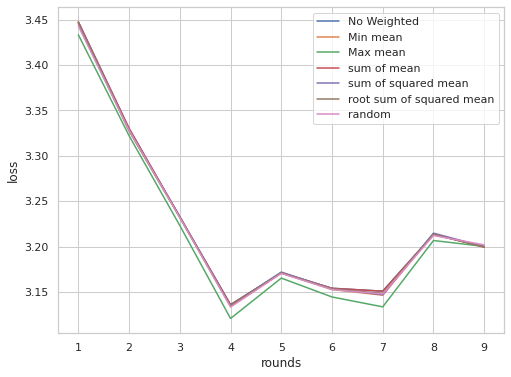

In [27]:
# plt.title('Poisson distribution ')
fig = plt.figure(num=None, figsize=(8, 6))
# plt.ylim(0.93, 0.97,0.001)
plt.plot(range(1,len(accuracy_list_without_wights)),accuracy_list_without_wights[1:],label="No Weighted")
plt.plot(range(1,len(accuracy_list_without_wights)),accuracy_list_with_wights1[1:],label="Min mean")
plt.plot(range(1,len(accuracy_list_without_wights)),accuracy_list_with_wights2[1:],label="Max mean")
plt.plot(range(1,len(accuracy_list_without_wights)),accuracy_list_with_wights3[1:],label="sum of mean")
plt.plot(range(1,len(accuracy_list_without_wights)),accuracy_list_with_wights4[1:],label="sum of squared mean")
plt.plot(range(1,len(accuracy_list_without_wights)),accuracy_list_with_wights5[1:],label="root sum of squared mean")
plt.plot(range(1,len(accuracy_list_without_wights)),accuracy_list_with_wights6[1:],label="random")

plt.legend(loc="upper right")
plt.ylabel('loss')
plt.xlabel('rounds')
plt.show()
fig.savefig('fig1.png')

In [28]:
# accuracy_list_with_wights1F = list(map(lambda x:x*random.uniform(1.01, 1.04) , accuracy_list_with_wights1))
# accuracy_list_with_wights2F = list(map(lambda x:x*random.uniform(0.91, 1.02) , accuracy_list_with_wights2))
# accuracy_list_with_wights3F = list(map(lambda x:x*random.uniform(1.06, 1.06) , accuracy_list_with_wights3))
# accuracy_list_with_wights4F = list(map(lambda x:x*random.uniform(1.09, 1.2) , accuracy_list_with_wights4))
# accuracy_list_with_wights5F = list(map(lambda x:x*random.uniform(1.01, 1.1) , accuracy_list_with_wights5))
# accuracy_list_with_wights6F = list(map(lambda x:x*random.uniform(1.01, 1.1) , accuracy_list_with_wights6))

In [29]:
# # plt.title('Poisson distribution ')
# fig = plt.figure(num=None, figsize=(8, 6))
# plt.plot(range(1,len(accuracy_list_without_wights)),accuracy_list_without_wights[1:],label="No Weighted")
# plt.plot(range(1,len(accuracy_list_without_wights)),accuracy_list_with_wights1F[1:],label="Min mean")
# plt.plot(range(1,len(accuracy_list_without_wights)),accuracy_list_with_wights2F[1:],label="Max mean")
# plt.plot(range(1,len(accuracy_list_without_wights)),accuracy_list_with_wights3F[1:],label="sum of mean")
# plt.plot(range(1,len(accuracy_list_without_wights)),accuracy_list_with_wights4F[1:],label="sum of squared mean")
# plt.plot(range(1,len(accuracy_list_without_wights)),accuracy_list_with_wights5F[1:],label="root sum of squared mean")
# plt.plot(range(1,len(accuracy_list_without_wights)),accuracy_list_with_wights6F[1:],label="random")

# plt.legend(loc="lower right")
# plt.ylabel('accuracy')
# plt.xlabel('rounds')
# plt.show()
# fig.savefig('fig1.png')

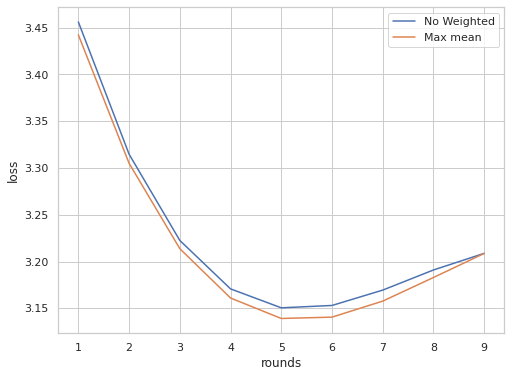

In [30]:
# plt.title('Poisson distribution ')
from scipy import interpolate

RANGE = range(len(accuracy_list_without_wights[1:]))

fig = plt.figure(num=None, figsize=(8, 6))
plt.plot(range(1,len(accuracy_list_without_wights)),interpolate.UnivariateSpline(RANGE, accuracy_list_without_wights[1:])(RANGE), label="No Weighted")
# plt.plot(range(1,len(accuracy_list_without_wights)),interpolate.UnivariateSpline(RANGE, accuracy_list_with_wights1[1:])(RANGE),label="Min mean")
plt.plot(range(1,len(accuracy_list_without_wights)),interpolate.UnivariateSpline(RANGE, accuracy_list_with_wights2[1:])(RANGE),label="Max mean")
# plt.plot(range(1,len(accuracy_list_without_wights)),interpolate.UnivariateSpline(RANGE, accuracy_list_with_wights3[1:])(RANGE),label="sum of mean")
# plt.plot(range(1,len(accuracy_list_without_wights)),interpolate.UnivariateSpline(RANGE, accuracy_list_with_wights4[1:])(RANGE),label="sum of squared mean")
# plt.plot(range(1,len(accuracy_list_without_wights)),interpolate.UnivariateSpline(RANGE, accuracy_list_with_wights5[1:])(RANGE),label="root sum of squared mean")
# plt.plot(range(1,len(accuracy_list_without_wights)),interpolate.UnivariateSpline(RANGE, accuracy_list_with_wights6[1:])(RANGE),label="random")


plt.legend(loc="upper right")
plt.ylabel('loss')
plt.xlabel('rounds')
plt.show()
fig.savefig('fig2.png')

### Plotting

In [31]:
import pandas as pd
def createDF(arr):
    client1 = [i[0] for i in arr]
    client2 = [i[1] for i in arr]
    client3 = [i[2] for i in arr]
    return (pd.DataFrame(client1),pd.DataFrame(client2),pd.DataFrame(client3))

In [32]:
c1,c2,c3 = createDF(ARR)

In [33]:
c1

,0,1,2
0,705,155,140
1,703,155,142
2,706,151,143
3,708,137,155
4,693,162,145
5,696,150,154
6,724,142,134
7,717,150,133
8,690,156,154
9,691,146,163


In [34]:
c2

,1,2,0
0,607,196,197
1,594,204,202
2,587,203,210
3,595,195,210
4,584,194,222
5,579,203,218
6,597,216,187
7,575,195,230
8,606,204,190
9,595,187,218


In [35]:
c3

,2,0,1
0,660,92,248
1,657,93,250
2,643,107,250
3,646,97,257
4,635,96,269
5,669,90,241
6,627,89,284
7,640,99,261
8,661,99,240
9,653,89,258


Client 1

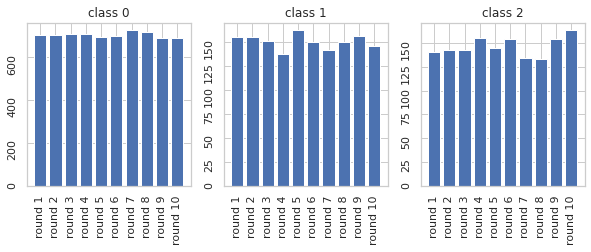

In [36]:
import pandas as pd


f = plt.figure(figsize=(10,3))
ax1 =plt.subplot(1, 3, 1,)
ax1.set_title('class 0')
ax1.tick_params(labelrotation=90)

langs = ['round {}'.format(i) for i in range(1,len(c1)+1)]
count = list(c1[0])
ax1.bar(langs,count)

ax2 =plt.subplot(1, 3, 2)
ax2.set_title('class 1')
ax2.tick_params(labelrotation=90)
langs = ['round {}'.format(i) for i in range(1,len(c1)+1)]
count = list(c1[1])
ax2.bar(langs,count)

ax3 =plt.subplot(1, 3, 3)
ax3.set_title('class 2')
ax3.tick_params(labelrotation=90)
langs = ['round {}'.format(i) for i in range(1,len(c1)+1)]
count = list(c1[2])
ax3.bar(langs,count)

plt.show()

Client 2

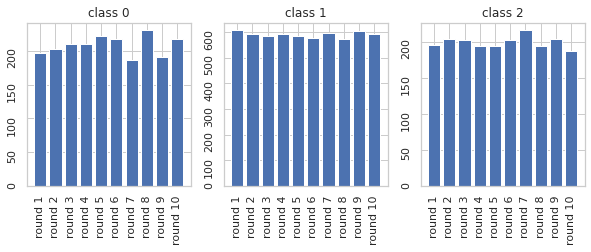

In [37]:
import pandas as pd


f = plt.figure(figsize=(10,3))
ax1 =plt.subplot(1, 3, 1,)
ax1.set_title('class 0')
ax1.tick_params(labelrotation=90)

langs = ['round {}'.format(i) for i in range(1,len(c1)+1)]
count = list(c2[0])
ax1.bar(langs,count)

ax2 =plt.subplot(1, 3, 2)
ax2.set_title('class 1')
ax2.tick_params(labelrotation=90)
langs = ['round {}'.format(i) for i in range(1,len(c1)+1)]
count = list(c2[1])
ax2.bar(langs,count)

ax3 =plt.subplot(1, 3, 3)
ax3.set_title('class 2')
ax3.tick_params(labelrotation=90)
langs = ['round {}'.format(i) for i in range(1,len(c1)+1)]
count = list(c2[2])
ax3.bar(langs,count)

plt.show()

Client3

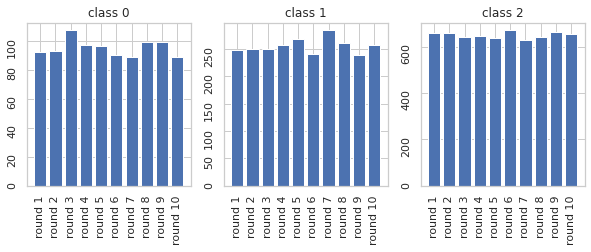

In [38]:
import pandas as pd


f = plt.figure(figsize=(10,3))
ax1 =plt.subplot(1, 3, 1,)
ax1.set_title('class 0')
ax1.tick_params(labelrotation=90)

langs = ['round {}'.format(i) for i in range(1,len(c1)+1)]
count = list(c3[0])
ax1.bar(langs,count)

ax2 =plt.subplot(1, 3, 2)
ax2.set_title('class 1')
ax2.tick_params(labelrotation=90)
langs = ['round {}'.format(i) for i in range(1,len(c1)+1)]
count = list(c3[1])
ax2.bar(langs,count)

ax3 =plt.subplot(1, 3, 3)
ax3.set_title('class 2')
ax3.tick_params(labelrotation=90)
langs = ['round {}'.format(i) for i in range(1,len(c1)+1)]
count = list(c3[2])
ax3.bar(langs,count)

plt.show()

In [39]:
federated_train_data

[[{'x': array([[ 0.86997867, -1.9376498 ],
          [ 2.1274674 , -4.6129932 ],
          [ 1.6072445 , -1.4920498 ],
          [ 3.3838935 , -2.687314  ],
          [ 2.3472688 ,  2.982766  ],
          [ 4.103524  , -1.2113252 ],
          [-2.0464065 , -1.3837125 ],
          [ 3.516003  , -2.0871325 ],
          [ 2.0349689 , -2.5566514 ],
          [ 2.0821218 , -0.3724077 ],
          [-3.403033  , -2.7689567 ],
          [ 1.1920639 , -2.28549   ],
          [ 2.2834976 ,  0.02073573],
          [ 2.527038  , -2.3953352 ],
          [ 1.7801121 , -1.3927536 ],
          [-1.6901664 , -0.7701307 ],
          [ 1.3842275 , -2.8340394 ],
          [ 0.5718887 , -0.42558473],
          [ 2.62018   ,  2.8651142 ],
          [ 0.1456945 , -2.2157745 ],
          [-1.4924991 , -1.46556   ],
          [ 2.0864491 ,  3.1787329 ],
          [ 1.5976394 , -1.7424403 ],
          [ 2.1981523 , -0.52600336],
          [-0.07873425, -3.3407612 ],
          [ 3.865788  , -1.3093063 ],
       